In [2]:
import os
import random
import shutil
import time
import warnings

import torch
import numpy as np
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torchinfo import summary

from utils.utils import cutmix, cutmix_criterion
from utils.config import config
from model import MobileFormer

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt

In [3]:
#load the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# create model
# assert args.name in ['mf52', 'mf294', 'mf508'] 
model_name = 'mf52'

print('create model {}'.format(model_name))
cfg = config[model_name]
model = MobileFormer(cfg)
model = model.to(device)

create model mf52


In [5]:
checkpoint = torch.load('./checkpoint/model_best.pth.tar',map_location=device)
start_epoch = checkpoint['epoch']
best_acc1 = checkpoint['best_acc1']
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [6]:
path = './data'
traindir = os.path.join(path, 'train')
testdir = os.path.join(path, 'test')

cinic_mean = [0.47889522, 0.47227842, 0.43047404]
cinic_std = [0.24205776, 0.23828046, 0.25874835]

print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean = cinic_mean,std = cinic_std)
])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = cinic_mean,std = cinic_std),
])

trainset = datasets.ImageFolder(traindir, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, num_workers=1)

testset = datasets.ImageFolder(testdir, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=200, shuffle=False, num_workers=1)

==> Preparing data..


In [7]:
print('trainset lens: ', trainset.__len__())
print('testset lens: ', testset.__len__())

# print the label
classes  = trainset.classes
class_to_idx = trainset.class_to_idx
print(class_to_idx)

trainset lens:  90000
testset lens:  90000
{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


In [14]:
def plot_confusion_matrix(labels, pred_labels, classes,name):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)
    plt.savefig("./checkpoint/" + name)
    
def eval_peformance(model,name):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    
    test_loss = 0
    correct = 0
    labels = []
    probs = []
    with torch.no_grad():
        #end = time.time()
        for i, (images, target) in enumerate(test_loader):
            
            
            images = images.to(device)
            target = target.to(device)

            # compute output
            output = model(images)
            loss = criterion(output, target)
            test_loss+=loss.item()
            
            
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            
            labels.append(target)
            probs.append(pred)
            
        
        test_loss /= len(test_loader.dataset)
        test_acc = correct / float(len(test_loader.dataset))
        

        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset), 100. * test_acc))
    
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)
    
    plot_confusion_matrix(labels.cpu(), probs.cpu(), classes,name) 


    
def get_data_from_txt(path):
    list = []
    with open(path,'r') as f:
        for line in f:
            list.append(float(line.strip('\n'))) 
    return list

def plot_record_data(train_list,test_list,label):
    plt.figure()
    ax=plt.axes()
    plt.xlabel('Round')  
    plt.ylabel(label)   

    plt.plot(range(len(train_list)), train_list, label="train "+ label)
    plt.plot(range(len(test_list)), test_list, label="test "+label)
    plt.legend(loc='upper right')
    plt.title(label+" curve")
    plt.savefig("./checkpoint/"+label+"_curve.png")



In [15]:
record_path="./exp_record"
train_loss_txt = os.path.join(record_path,"train_loss.txt")
train_acc_txt = os.path.join(record_path,"train_acc.txt")
test_loss_txt = os.path.join(record_path,"test_loss.txt")
test_acc_txt = os.path.join(record_path,"test_acc.txt")

In [16]:
train_loss_list=get_data_from_txt(train_loss_txt)
train_acc_list=get_data_from_txt(train_acc_txt)
test_loss_list=get_data_from_txt(test_loss_txt)
test_acc_list=get_data_from_txt(test_acc_txt)

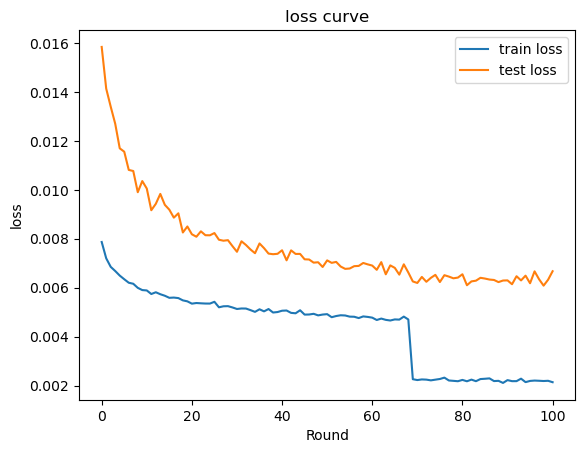

In [18]:
plot_record_data(train_loss_list,test_loss_list,'loss')

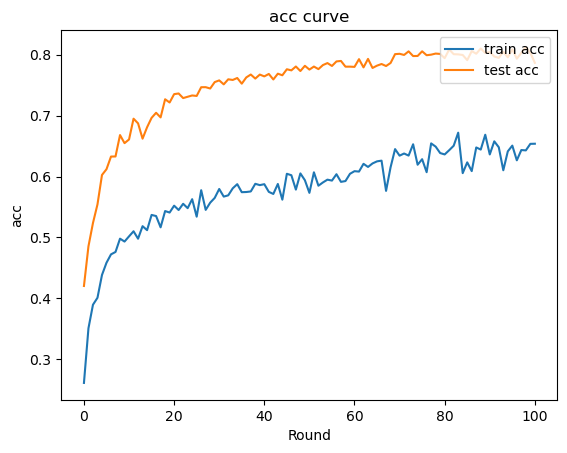

In [19]:
plot_record_data(train_acc_list,test_acc_list,'acc')


Test set: Average loss: 0.0030, Accuracy: 73138/90000 (81.3%)



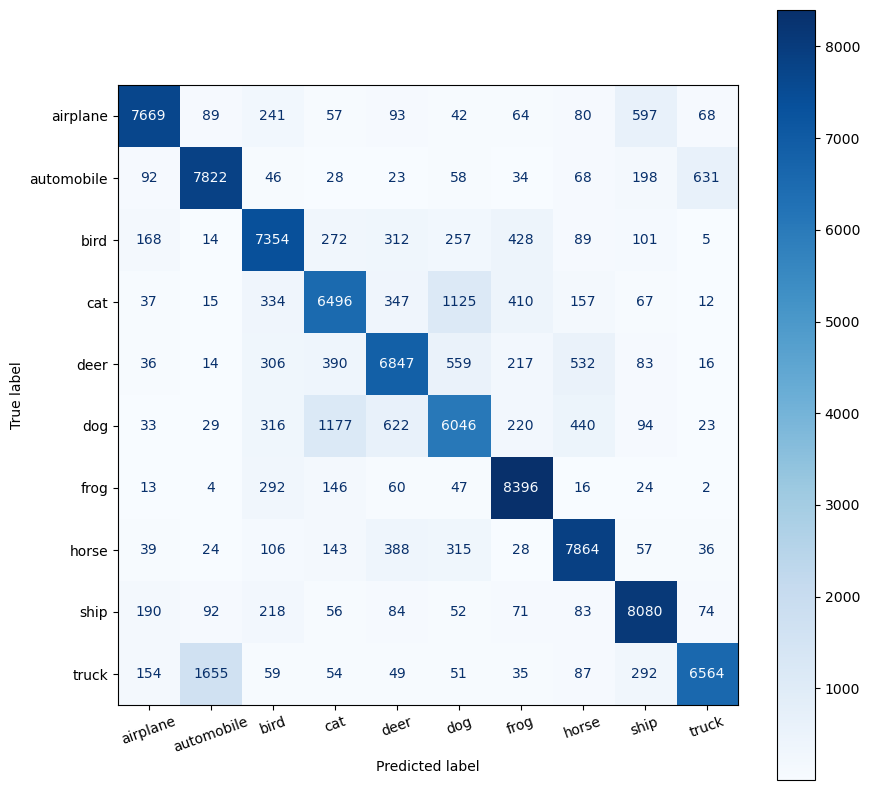

In [20]:
eval_peformance(model,"confusion_matrix.png")